<a href="https://colab.research.google.com/github/abbask31/Autism-Facial-Recognition/blob/main/autism_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Pillow==8.3.1
!pip install opencv-python==4.5.3.56
!pip install torch==1.9.0
!pip install torchvision==0.10.0
!pip install kaggle==1.5.12

In [1]:
from google.colab import files

uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d cihan063/autism-image-data


 98% 225M/229M [00:08<00:00, 26.9MB/s]
100% 229M/229M [00:08<00:00, 27.5MB/s]


In [4]:
import zipfile

with zipfile.ZipFile('autism-image-data.zip', 'r') as zip_ref:
    zip_ref.extractall('autism-image-data')


In [5]:
import os
import shutil

dataset_dir = '/content/autism-image-data/AutismDataset'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Create directories to organize the images
train_autistic_dir = os.path.join(train_dir, 'Autistic')
train_non_autistic_dir = os.path.join(train_dir, 'Non_Autistic')
test_autistic_dir = os.path.join(test_dir, 'Autistic')
test_non_autistic_dir = os.path.join(test_dir, 'Non_Autistic')

os.makedirs(train_autistic_dir, exist_ok=True)
os.makedirs(train_non_autistic_dir, exist_ok=True)
os.makedirs(test_autistic_dir, exist_ok=True)
os.makedirs(test_non_autistic_dir, exist_ok=True)

# Move images to the directories in the train set
for image_name in os.listdir(train_dir):
    src_path = os.path.join(train_dir, image_name)
    if image_name.startswith('Autistic') and not os.path.isdir(src_path):
        dest_path = os.path.join(train_autistic_dir, image_name)
        shutil.move(src_path, dest_path)
        print(f'{image_name} --> {train_autistic_dir}')
    elif image_name.startswith('Non_Autistic') and not os.path.isdir(src_path):
        dest_path = os.path.join(train_non_autistic_dir, image_name)
        shutil.move(src_path, dest_path)
        print(f'{image_name} --> {train_non_autistic_dir}')

# Move images to the directories in the test set
for image_name in os.listdir(test_dir):
    src_path = os.path.join(test_dir, image_name)
    if image_name.startswith('Autistic') and not os.path.isdir(src_path):
        dest_path = os.path.join(test_autistic_dir, image_name)
        shutil.move(src_path, dest_path)
        print(f'{image_name} --> {test_autistic_dir}')
    elif image_name.startswith('Non_Autistic') and not os.path.isdir(src_path):
        dest_path = os.path.join(test_non_autistic_dir, image_name)
        shutil.move(src_path, dest_path)
        print(f'{image_name} --> {test_non_autistic_dir}')


Autistic.138.jpg --> /content/autism-image-data/AutismDataset/train/Autistic
Non_Autistic.1160.jpg --> /content/autism-image-data/AutismDataset/train/Non_Autistic
Non_Autistic.490.jpg --> /content/autism-image-data/AutismDataset/train/Non_Autistic
Non_Autistic.672.jpg --> /content/autism-image-data/AutismDataset/train/Non_Autistic
Autistic.878.jpg --> /content/autism-image-data/AutismDataset/train/Autistic
Non_Autistic.31.jpg --> /content/autism-image-data/AutismDataset/train/Non_Autistic
Non_Autistic.240.jpg --> /content/autism-image-data/AutismDataset/train/Non_Autistic
Autistic.864.jpg --> /content/autism-image-data/AutismDataset/train/Autistic
Autistic.35.jpg --> /content/autism-image-data/AutismDataset/train/Autistic
Non_Autistic.1141.jpg --> /content/autism-image-data/AutismDataset/train/Non_Autistic
Non_Autistic.580.jpg --> /content/autism-image-data/AutismDataset/train/Non_Autistic
Autistic.673.jpg --> /content/autism-image-data/AutismDataset/train/Autistic
Autistic.1126.jpg --

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

def display_images_from_folder(folder_path, num_images):
    images = os.listdir(folder_path)
    num_images = min(num_images, len(images))

    for i in range(num_images):
        image_path = os.path.join(folder_path, images[i])
        image = cv2.imread(image_path)
        
        # Display the image
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()



In [ ]:
def resize_images_in_folder(folder_path, target_size):
    images = os.listdir(folder_path)

    for image_name in images:
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)
        
        # Resize the image while maintaining the aspect ratio
        resized_image = cv2.resize(image, target_size)
        
        # Save the resized image back to the same location
        cv2.imwrite(image_path, resized_image)


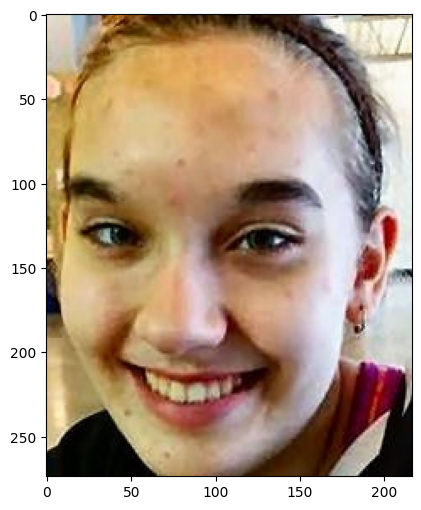

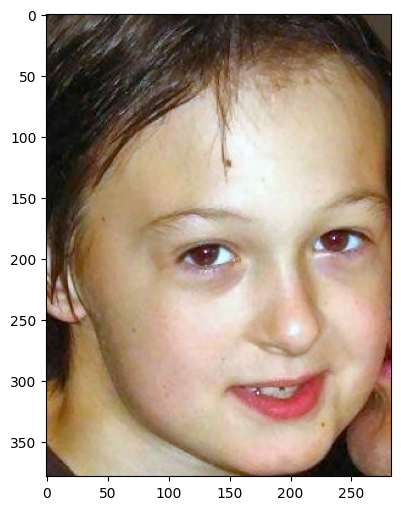

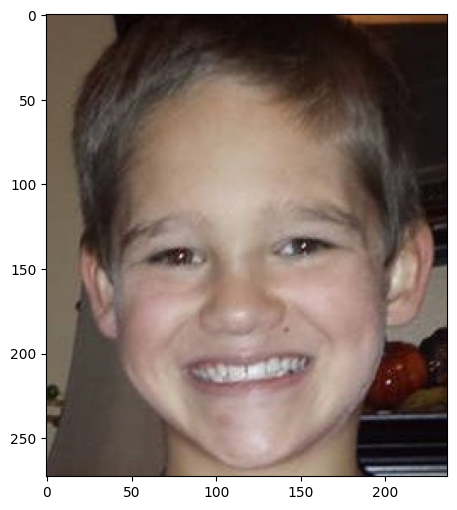

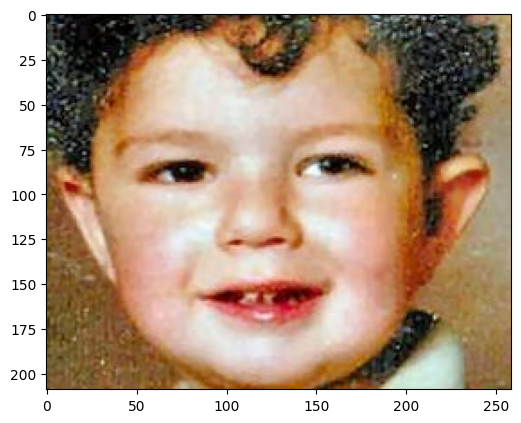

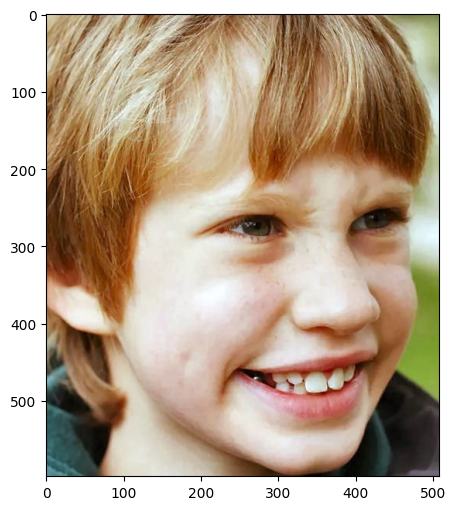

In [ ]:
# Before resizing
display_images_from_folder(train_autistic_dir, num_images=5)

In [ ]:
# Resize and interpolate all images to 224x224 (standard size for base model)
resize_shape = (224,224)
for dir in os.scandir(dataset_dir):
    # Resize each valid subdir
      resize_images_in_folder(f'{dataset_dir}/{dir.name}/Autistic', resize_shape)
      resize_images_in_folder(f'{dataset_dir}/{dir.name}/Non_Autistic', resize_shape)

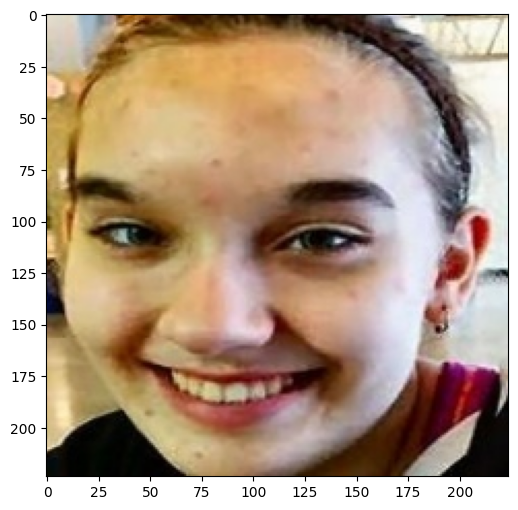

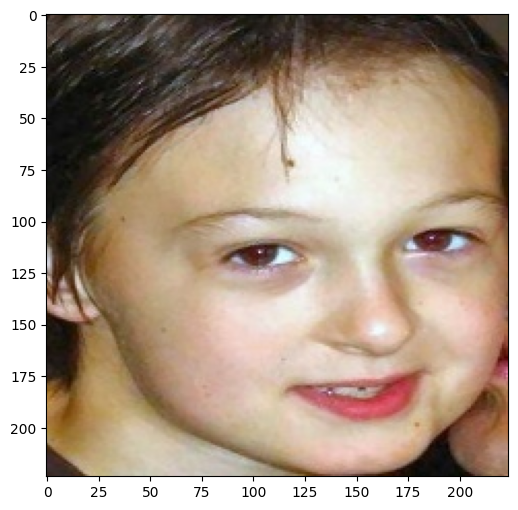

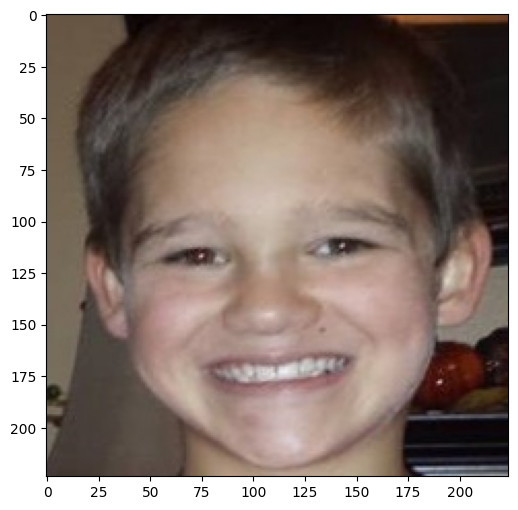

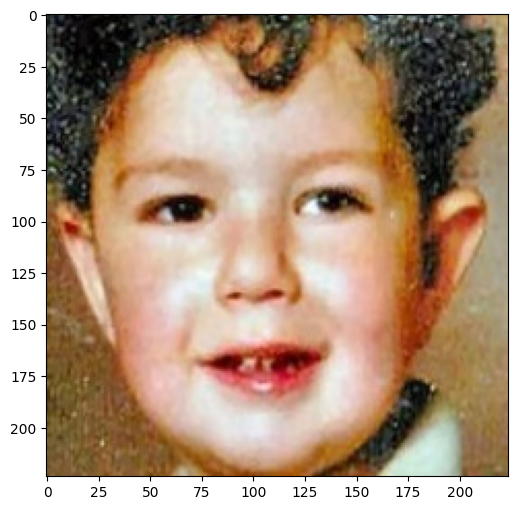

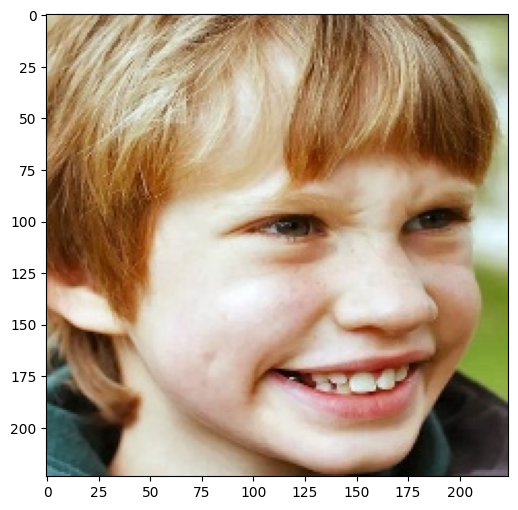

In [ ]:
# After resizing
display_images_from_folder(train_autistic_dir, num_images=5)

In [ ]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image


# Define the desired dimensions for your images
image_width = 224
image_height = 224

# Load and preprocess the images from the train directory
X_train = []
y_train = []
class_map = {'Autistic': 0, 'Non_Autistic': 1}  # Map class labels to numerical values
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    for file_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, file_name)
        image = Image.open(image_path)
        image = np.array(image)  # Convert to numpy array
        X_train.append(image)
        y_train.append(class_map[class_name])  # Map class labels to numerical values

# Convert the lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape the images to flatten them into 1D vectors
num_samples, _, _, num_channels = X_train.shape
X_train_flat = X_train.reshape(num_samples, image_width * image_height * num_channels)




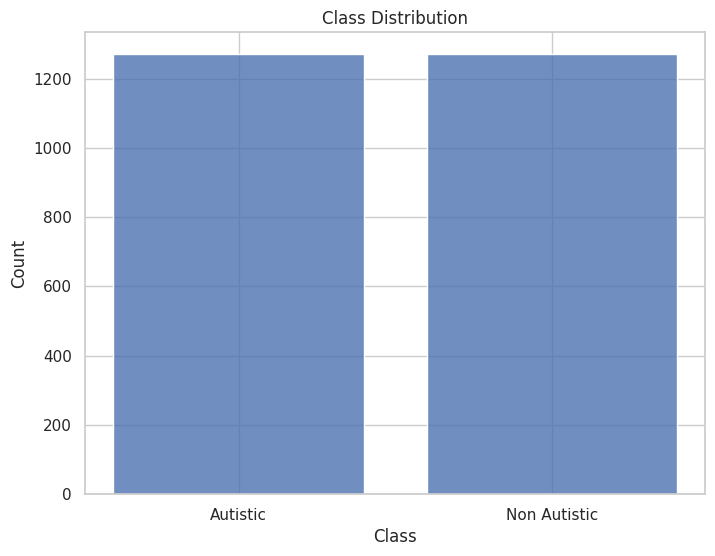

In [25]:
import seaborn as sns

# Set a seaborn style
sns.set(style='whitegrid')

# Count the number of samples in each class
class_counts = np.bincount(y_train)
class_labels = ['Autistic', 'Non Autistic']

# Plot the class distributions
plt.figure(figsize=(8, 6))
sns.histplot(data=y_train, bins=len(class_labels), discrete=True, shrink=0.8, alpha=0.8)
plt.xticks(range(len(class_labels)), class_labels)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

# Display the plot
plt.show()

In [17]:
# Apply PCA for initial dimensionality reduction
pca = PCA(n_components=35)  # You can adjust the number of components based on your dataset
X_pca = pca.fit_transform(X_train_flat)

# Apply t-SNE for further dimensionality reduction and visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

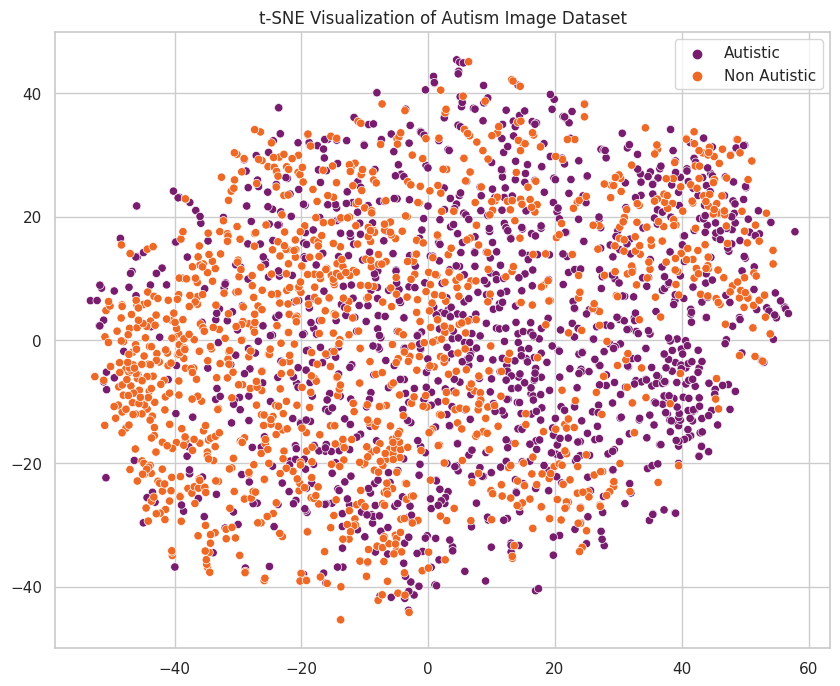

In [24]:
# Map numerical labels to label names
label_names = ['Autistic', 'Non Autistic']

# Set a seaborn style
sns.set(style='whitegrid')

# Plot the t-SNE visualization with Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train, palette='inferno')

# Get the handles and labels of the legend
handles, _ = plt.gca().get_legend_handles_labels()

# Create a new legend with label names
plt.legend(handles, label_names)

plt.title('t-SNE Visualization of Autism Image Dataset')

# Display the plot
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class RecognitionModel(nn.Module):
    def __init__(self):
        super(RecognitionModel, self).__init__()

        # Load VGG19 model
        self.base = models.vgg19(pretrained=True)
        for param in self.base.parameters():
            param.requires_grad = False
        
        # Modify the VGG19 classifier
        self.base.classifier = nn.Identity()  # Remove the default classifier layers
        
        # Define the remaining layers
        self.layers = nn.Sequential(
            nn.AdaptiveMaxPool2d(1), # Extract relevant features and then downsample
            nn.Flatten(), # flatten to 1d tensor for subsequency layers
            nn.Linear(in_features=512, out_features=512), # assists network in introducing non-linearity and recognizing complex patterns
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.LeakyReLU(negative_slope=0.2), # try to avoid dying relu problem
            # nn.Dropout(p=0.2),
            nn.Dropout(p=0.29), # avoid overfitting by dropping 29% of neurons
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=2),
            nn.Softmax(dim=1) # softmax for class predictions
        )
    
    def forward(self, x):
        # Apply the VGG19 base layers
        x = self.base.features(x)
        x = self.base.avgpool(x)
        
        # Apply the remaining layers
        x = self.layers(x)
        
        return x

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define the transforms for data preprocessing and augmentation
data_transforms = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(30),  # Adjust the angle as per your requirement
    # transforms.CenterCrop(180),
    # transforms.RandomInvert(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2)
])

valid_dir = os.path.join(dataset_dir, 'valid')

# Create the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=data_transforms)

# Create the data loaders
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)


In [ ]:
# learning_rate = 0.001
learning_rate = 0.0001
num_epochs = 10
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda')
model = RecognitionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.eval()

RecognitionModel(
  (base): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

Fold 1:
Epoch [1/10], Validation Accuracy: 70.67%
Epoch [2/10], Validation Accuracy: 74.02%
Epoch [3/10], Validation Accuracy: 72.24%
Epoch [4/10], Validation Accuracy: 75.20%
Epoch [5/10], Validation Accuracy: 74.41%
Epoch [6/10], Validation Accuracy: 75.59%
Epoch [7/10], Validation Accuracy: 77.36%
Epoch [8/10], Validation Accuracy: 73.23%
Epoch [9/10], Validation Accuracy: 76.38%
Epoch [10/10], Validation Accuracy: 76.57%
Fold 2:
Epoch [1/10], Validation Accuracy: 84.65%
Epoch [2/10], Validation Accuracy: 85.63%
Epoch [3/10], Validation Accuracy: 84.65%
Epoch [4/10], Validation Accuracy: 82.09%
Epoch [5/10], Validation Accuracy: 84.65%
Epoch [6/10], Validation Accuracy: 85.24%
Epoch [7/10], Validation Accuracy: 85.24%
No improvement in validation accuracy for 5 epochs. Stopping training.
Training finished.


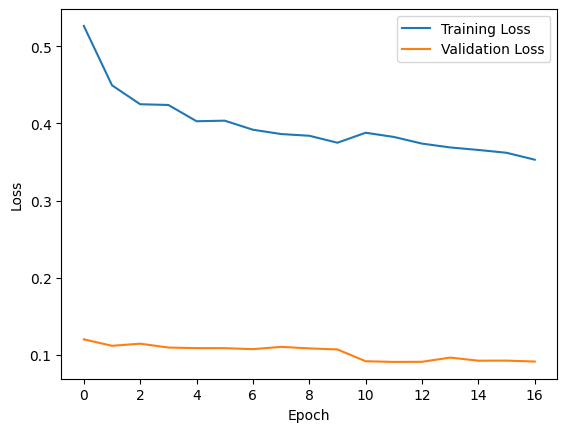

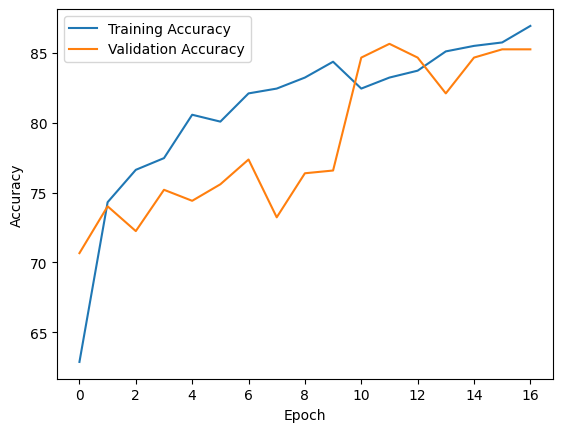

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import sampler

# Lists to store the metrics
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

train_indices = np.arange(len(train_dataset))
best_model = None
best_accuracy = 0
patience = 5  # Number of epochs to wait for improvement
no_improvement_counter = 0

# Initialize the k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True)

# Iterate over the k folds
for fold, (train_index, valid_index) in enumerate(kf.split(train_indices)):
    print(f"Fold {fold + 1}:")

    # Create the data samplers
    train_sampler = sampler.SubsetRandomSampler(train_index)
    valid_sampler = sampler.SubsetRandomSampler(valid_index)

    # Create the data loaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler)
    valid_loader = DataLoader(train_dataset, batch_size=16, sampler=valid_sampler)

    for epoch in range(num_epochs):

        model.train()
        train_loss = 0.0
        total_correct = 0
        total_samples = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        train_accuracy = 100 * total_correct / total_samples
        train_accuracies.append(train_accuracy)

        # Validate the model after each epoch
        model.eval()
        valid_loss = 0.0
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                # Calculate loss
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)

                # Calculate accuracy
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

            valid_loss /= len(valid_loader.dataset)
            valid_losses.append(valid_loss)

            accuracy = 100 * total_correct / total_samples
            valid_accuracies.append(accuracy)

            print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {accuracy:.2f}%')

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = model.state_dict()
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1
                if no_improvement_counter >= patience:
                    print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.')
                    break

    if no_improvement_counter >= patience:
        break

print('Training finished.')

# Plot the loss curve
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
print(f"Validation Accuracy: {best_accuracy}")
print(f"Training Accuracy: {sum(train_accuracies) / len(train_accuracies)}")

Validation Accuracy: 85.62992125984252
Training Accuracy: 80.97498842056505


Average Test Accuracy: 75.00%
Average Test Accuracy: 71.88%
Average Test Accuracy: 77.08%
Average Test Accuracy: 76.56%
Average Test Accuracy: 75.00%
Average Test Accuracy: 76.04%
Average Test Accuracy: 74.11%
Average Test Accuracy: 76.56%
Average Test Accuracy: 77.78%
Average Test Accuracy: 78.12%
Average Test Accuracy: 78.98%
Average Test Accuracy: 79.69%
Average Test Accuracy: 81.25%
Average Test Accuracy: 81.25%
Average Test Accuracy: 81.25%
Average Test Accuracy: 80.47%
Average Test Accuracy: 79.41%
Average Test Accuracy: 78.82%
Average Test Accuracy: 79.06%


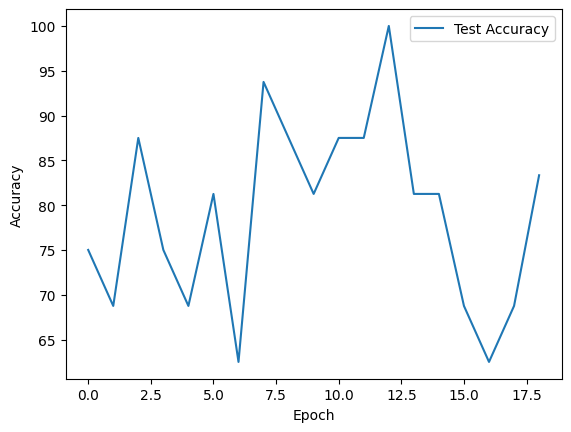

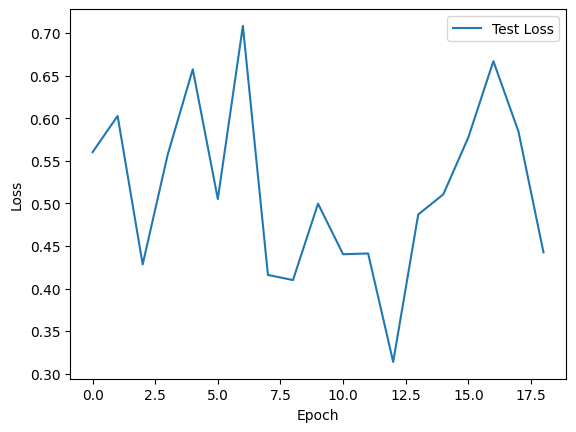

In [ ]:
test_acc_history = []
test_loss_history = []

model.load_state_dict(best_model)  # Load the best model state

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Calculate accuracy and loss
        total_samples = labels.size(0)
        total_correct = (predicted == labels).sum().item()
        accuracy = 100 * total_correct / total_samples
        loss = criterion(outputs, labels)

        test_acc_history.append(accuracy)
        test_loss_history.append(loss.item())
        
        # Calculate average accuracy
        average_accuracy = sum(test_acc_history) / len(test_acc_history)
        print(f'Average Test Accuracy: {average_accuracy:.2f}%')

# Plot accuracy
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'model_82.pt')

In [ ]:
# Model Analysis
model = RecognitionModel().to(device)
state_dict = torch.load('/content/model_82.pt')
model.load_state_dict(state_dict)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RecognitionModel(
  (base): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

In [ ]:
true_labels = []
predicted_labels = []



In [ ]:
with torch.no_grad():
  for images, labels in test_loader:
      # Forward pass through the model
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      
      # Convert tensors to numpy arrays
      # Convert tensors to CPU
      labels = labels.cpu().numpy()
      predicted = predicted.cpu().numpy()

      
      # Append true and predicted labels to the lists
      true_labels.extend(labels)
      predicted_labels.extend(predicted)

In [ ]:
import numpy as np
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

Class 0 - Precision: 0.80, Recall: 0.80, F1: 0.80
Class 1 - Precision: 0.80, Recall: 0.80, F1: 0.80


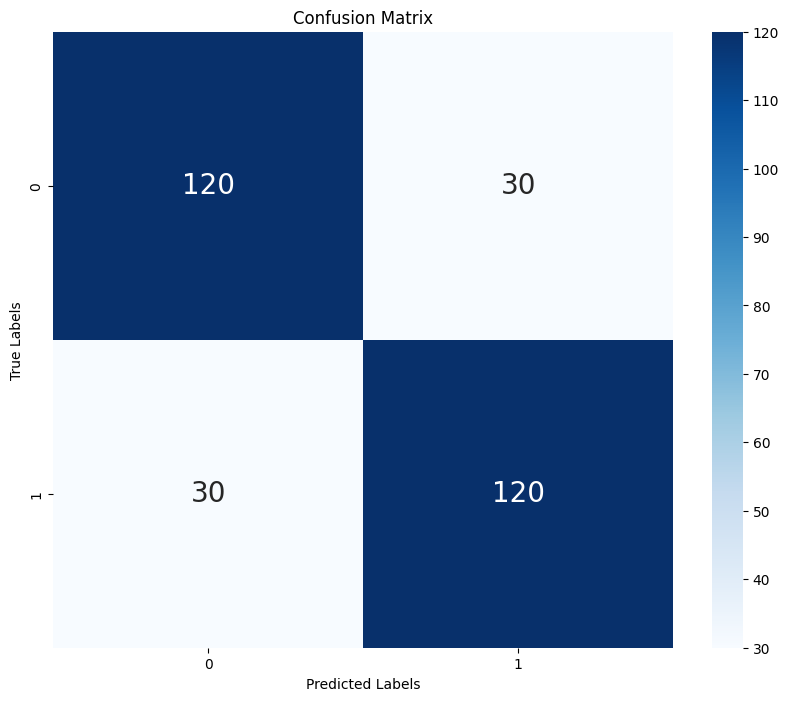

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)

# Calculate precision and recall
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)
# Print precision and recall
for i in range(len(precision)):
    print(f"Class {i} - Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1: {f1[i]:.2f}")


# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})  # Increase font size with annot_kws
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
plt.savefig("confusion_matrix.png")
